In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm  # Ensure tqdm is imported



# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out


# Load and preprocess data
data = pd.read_csv('Combined_AAPL_Historical_Data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Date_days'] = (data['Date'] - data['Date'].min()).dt.days

# Convert 'Price', 'Open', 'High', 'Low' to float
for column in ['Price']:
    data[column] = data[column].astype(float)

# Use 'Date_days' and other relevant columns as features
features = data[['Price']].values

# Use 'Price' as target
target = data['Price'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Initialize the network
input_size = X_train.shape[1]
hidden_size = 1024  # Example size, can be tuned
output_size = 1

net = Net(input_size, hidden_size, output_size)

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Loss and optimizer
criterion = nn.MSELoss()  # Corrected line
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Example value, can be adjusted
with tqdm(range(num_epochs), unit="epoch") as tepochs:
    for epoch in tepochs:
        tepochs.set_description(f"Epoch {epoch+1}")

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Optionally, update the progress bar with the latest loss value
        tepochs.set_postfix(loss=loss.item())


# Evaluate the model
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = net(X_test_tensor.to(device))
    mse = mean_squared_error(y_test_tensor.cpu(), predictions.cpu())
    print(f'Mean Squared Error: {mse}')


def date_to_days(date_str, reference_date):
    """Convert input date string to 'Date_days' relative to a reference date."""
    date = pd.to_datetime(date_str)
    return (date - reference_date).days

  0%|          | 0/100 [00:00<?, ?epoch/s]

Mean Squared Error: 0.01916208304464817


In [2]:


def predict_price(date_str, model, scaler, reference_date, data):
    """Predict the 'Close/Last' price for a given date."""
    model.eval()  # Set the model to evaluation mode
    date_days = date_to_days(date_str, reference_date)
    date_days_scaled = scaler.transform([[date_days]])  # Scale the 'Date_days' feature

    # Convert to tensor and move to device
    date_tensor = torch.tensor(date_days_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        prediction = model(date_tensor).item()  # Get the prediction

    # Check if the given date is within the dataset
    if pd.to_datetime(date_str) in data['Date'].values:
        actual_price = data.loc[data['Date'] == pd.to_datetime(date_str), 'Price'].values[0]
        loss = abs(prediction - actual_price)
        print(f'Date: {date_str} | Prediction: ${prediction:.2f} | Actual: ${actual_price:.2f} | Loss: ${loss:.2f}')
    else:
        print(f'Date: {date_str} | Predicted Close/Last price: ${prediction:.2f}')


# Prediction loop
reference_date = data['Date'].min()  # Reference date to calculate 'Date_days'
while True:
    date_str = input("Enter a date in MM/DD/YYYY format (or type 'exit' to quit): ")
    if date_str.lower() == 'exit':
        break

    predict_price(date_str, net, scaler, reference_date, data)

Date: 1/29/2023 | Predicted Close/Last price: $15521.79
Date: 2/29/2024 | Prediction: $15921.34 | Actual: $180.61 | Loss: $15740.73


DateParseError: Unknown datetime string format, unable to parse: exot, at position 0

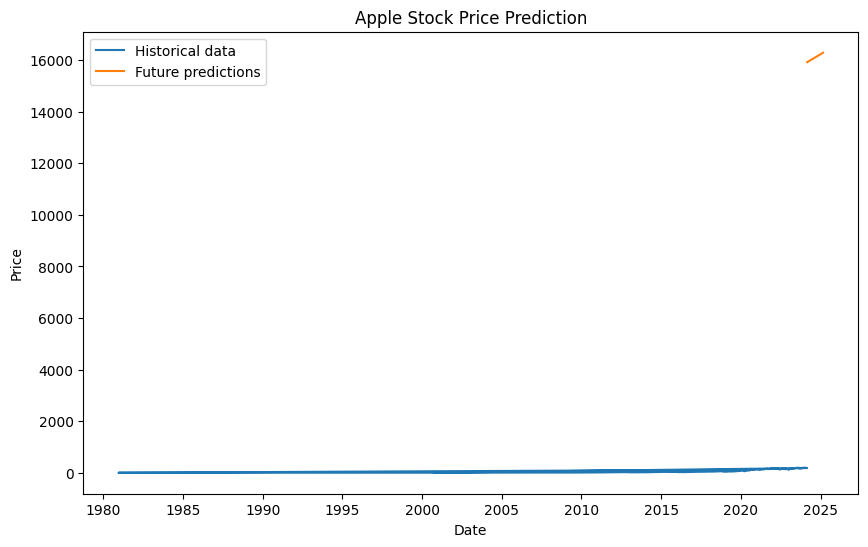

In [5]:
# graph future data up to a year
import matplotlib.pyplot as plt

# Generate future dates
future_dates = pd.date_range(start=data['Date'].max() + pd.DateOffset(days=1), periods=365)

# Rest of the code remains the same

# Convert future dates to 'Date_days'
future_dates_days = (future_dates - data['Date'].min()).days.values

# Scale the 'Date_days' feature
future_dates_scaled = scaler.transform(future_dates_days.reshape(-1, 1))

# Convert to tensor and move to device
future_dates_tensor = torch.tensor(future_dates_scaled, dtype=torch.float32).to(device)

# Get the predictions
with torch.no_grad():
    future_predictions = net(future_dates_tensor).cpu().numpy()
    
# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(data['Date'].values, data['Price'].values, label='Historical data')
plt.plot(future_dates, future_predictions.flatten(), label='Future predictions')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
